In [11]:
library(RSQLite)
library(syuzhet)
library(countrycode)
library(qdapDictionaries)
library(ggplot2)
library(dplyr)
library(tm)
library(RColorBrewer)
library(wordcloud)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: NLP

Attaching package: 'NLP'

The following object is masked from 'package:ggplot2':

    annotate



In [10]:
#install.packages('wordcloud', repos='http://cran.us.r-project.org')

package 'wordcloud' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\jagpreet\AppData\Local\Temp\Rtmp4y9H9A\downloaded_packages


In [54]:
setwd("E://Data Science/Hillary Clinton Email/output/")
db <- dbConnect(dbDriver("SQLite"), "database.sqlite")

In [15]:
#Give details about the SQL structure. Just like R's str output.
sample <- dbGetQuery(db, "PRAGMA table_info(Emails)")
print(sample)

   cid                         name    type notnull dflt_value pk
1    0                           Id INTEGER       0       <NA>  1
2    1                    DocNumber    TEXT       0       <NA>  0
3    2              MetadataSubject    TEXT       0       <NA>  0
4    3                   MetadataTo    TEXT       0       <NA>  0
5    4                 MetadataFrom    TEXT       0       <NA>  0
6    5               SenderPersonId INTEGER       0       <NA>  0
7    6             MetadataDateSent    TEXT       0       <NA>  0
8    7         MetadataDateReleased    TEXT       0       <NA>  0
9    8              MetadataPdfLink    TEXT       0       <NA>  0
10   9           MetadataCaseNumber    TEXT       0       <NA>  0
11  10        MetadataDocumentClass    TEXT       0       <NA>  0
12  11             ExtractedSubject    TEXT       0       <NA>  0
13  12                  ExtractedTo    TEXT       0       <NA>  0
14  13                ExtractedFrom    TEXT       0       <NA>  0
15  14    

In [16]:
#Get all the emails sent by Hillary
Emails <- data.frame(dbGetQuery(db,"SELECT * FROM Emails"))

In [17]:
#Sentiment Analysis on Raw Text
data_raw_text<-get_nrc_sentiment(Emails$RawText)

In [18]:
#Columnwise sum of the each sentiment
sum_data_raw_text <- data.frame(colSums(data_raw_text[1:10]))

In [19]:
names(sum_data_raw_text)[1] <- "count"
sum_data_raw_text <- cbind("sentiment" = rownames(sum_data_raw_text), sum_data_raw_text)
rownames(sum_data_raw_text) <- NULL
senti_Raw_text <- sum_data_raw_text[1:10,]

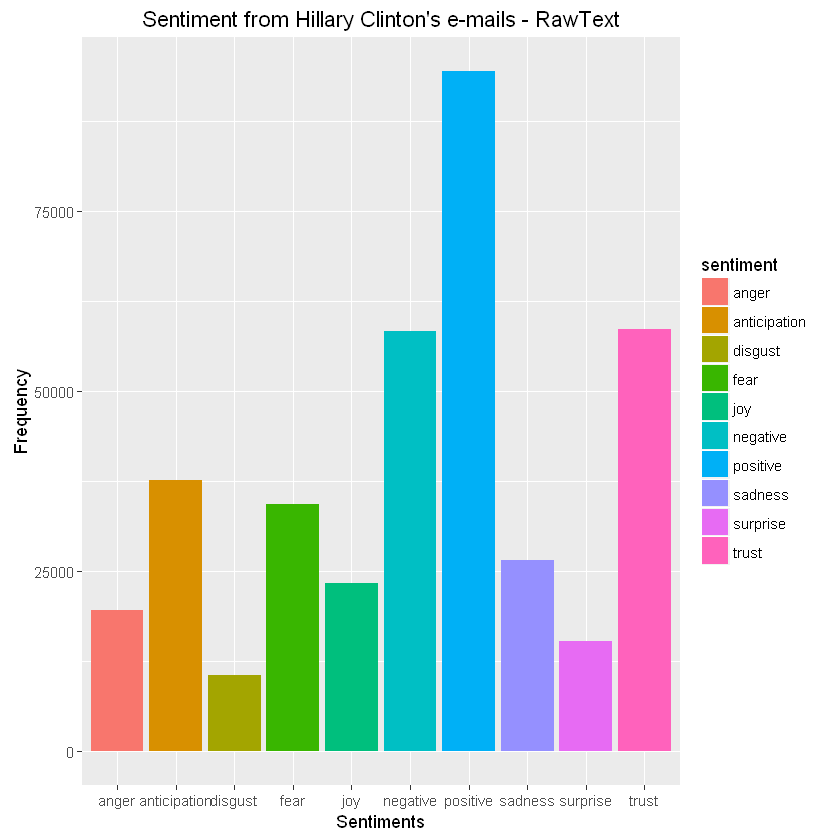

In [20]:
#Visualization
p1 <- ggplot(senti_Raw_text, aes(x=sentiment, y=count, fill=sentiment)) + geom_bar(stat = "identity") + labs(x="Sentiments", y="Frequency", title="Sentiment from Hillary Clinton's e-mails - RawText")
print(p1)

In [21]:
#Sentiment Analysis on ExtractedBodyText
data_ExtractedBodyText<-get_nrc_sentiment(Emails$ExtractedBodyText)

In [22]:
#Columnwise sum of the each sentiment
sum_data_ExtractedBodyText <- data.frame(colSums(data_ExtractedBodyText[1:10]))

In [23]:
names(sum_data_ExtractedBodyText)[1] <- "count"
sum_data_ExtractedBodyText <- cbind("sentiment" = rownames(sum_data_ExtractedBodyText), sum_data_ExtractedBodyText)
rownames(sum_data_ExtractedBodyText) <- NULL
senti_ExtractedBodyText <- sum_data_ExtractedBodyText[1:10,]

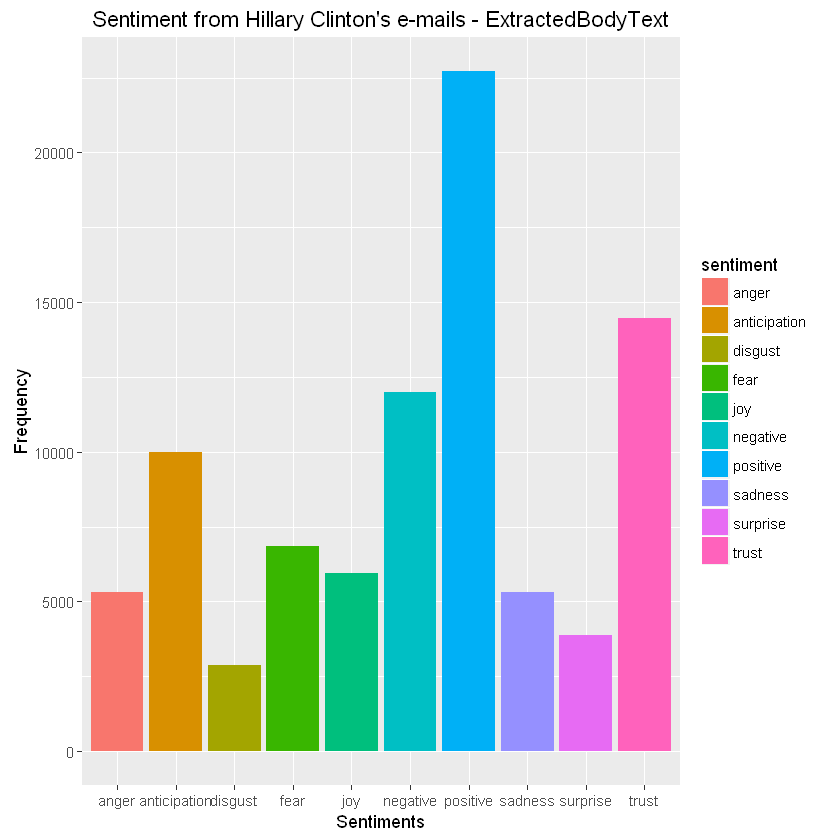

In [24]:
#Visualization from ExtractedBodyText
p2 <- ggplot(senti_ExtractedBodyText, aes(x=sentiment, y=count, fill=sentiment)) + geom_bar(stat = "identity") + labs(x="Sentiments", y="Frequency", title="Sentiment from Hillary Clinton's e-mails - ExtractedBodyText")
print(p2)

In [26]:
## WORD CLOUD ##

#Pull back all Email Subjects from all Persons not containing Replies, Forwards, and specific 
#terms/phrases: calls, call list, and schedule.
AllEmailSubjects <- dbGetQuery(db, 
                                 "select 
                                 ExtractedSubject
                                 EmailSubject from Emails ")
  
Filtered_AllEmailSubjects <- dbGetQuery(db, 
                               "select 
                               ExtractedSubject
                               EmailSubject from Emails em 
                               where em.ExtractedSubject != '' 
                               and em.ExtractedSubject NOT LIKE '%re:%'
                               and em.ExtractedSubject NOT LIKE '%fw%'
                               and em.ExtractedSubject NOT LIKE '%calls%'
                               and em.ExtractedSubject NOT LIKE '%call list%'
                               and em.ExtractedSubject NOT LIKE '%schedule%'")

In [28]:
# R code derived from: "Text Mining with R" 
# https://sites.google.com/site/miningtwitter/questions/talking-about/wordclouds/wordcloud1

# remove punctuation symbols
AllEmailSubjects = gsub("[[:punct:]]", "",AllEmailSubjects)

# create a corpus
x_corpus = Corpus(VectorSource(AllEmailSubjects))

In [29]:
# create document term matrix, remove punctuation, common stopwords,  
# and most common words. 

tdm = TermDocumentMatrix(x_corpus,
                         control = list(removePunctuation = TRUE,
                                        stopwords = c(stopwords("SMART"),stopwords("english")),
                                        removeNumbers = TRUE,tolower = TRUE))

In [30]:
# define tdm as matrix
m = as.matrix(tdm)
# get word counts in decreasing order
word_freqs = sort(rowSums(m), decreasing=TRUE)
# create a data frame with words and their frequencies
dm = data.frame(word=names(word_freqs), freq=word_freqs)

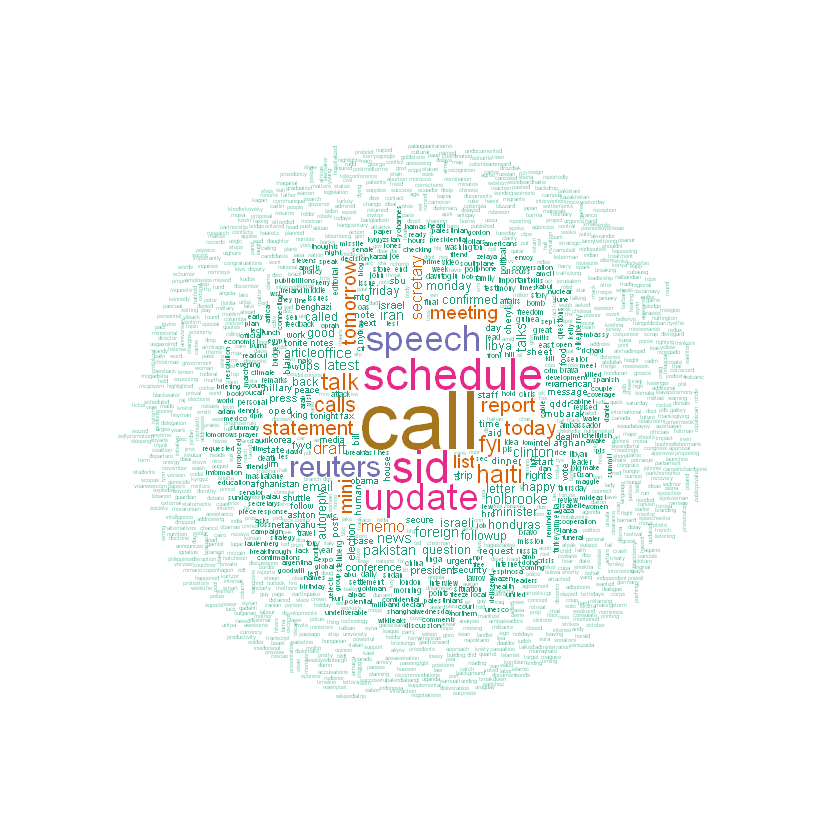

In [31]:
# plot wordcloud with Title
wordcloud(dm$word,dm$freq,scale=c(4,0.25),random.order=FALSE,colors=brewer.pal(7,"Dark2"))



In [32]:
## Who is polite to Hillary ?? ##

In [33]:
db <- dbConnect(dbDriver("SQLite"), "database.sqlite")

In [34]:
emailsToHillary <- dbGetQuery(db, "SELECT ExtractedFrom, ExtractedBodyText FROM Emails e INNER JOIN Persons p ON e.SenderPersonId=P.Id WHERE p.Name!='Hillary Clinton'  AND e.ExtractedBodyText != ''")


In [35]:
# Count how often there is a match to please/thanks (or similar) in the email body
# Get this as a factor (Polite/Impolite)
emailsToHillary$Politeness<-factor(ifelse(rowSums(sapply(c("please", "pls", "thank", "thx", "thanks", "request","req"), grepl, emailsToHillary$ExtractedBodyText, ignore.case=T))>0, "Polite", "Impolite"))


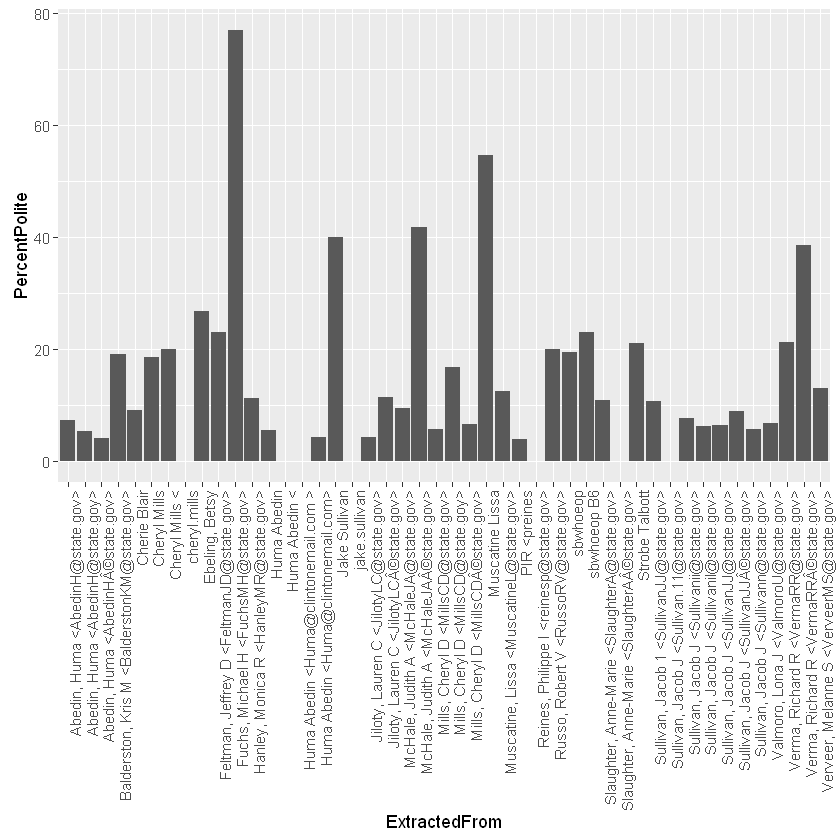

In [36]:
#Look at Politeness breakdown by individual sender
#Looks like there needs to be a bit more cleaning up of these, or I am handling them wrong
#Quite a few repeated names
emailsToHillary %>% select(ExtractedFrom, Politeness) %>%
  filter(ExtractedFrom!="") %>%
  group_by(ExtractedFrom) %>% 
  summarise(EmailCount= n(), PercentPolite=100*mean(Politeness=="Polite")) %>%
  filter(EmailCount>=10) %>%
  ggplot(aes(x = ExtractedFrom, y = PercentPolite)) + 
  geom_bar(stat = "identity") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

In [37]:
# CLose to 75 Percent mails from Michael Fuchs has polite words.
# He looks junior to Hillary and has good manners.

In [ ]:
## WITH WHOME HILLARY IS POLITE ??? ##


In [46]:
emailsFromHillary <- dbGetQuery(db, "SELECT ExtractedBodyText, ExtractedFrom, ExtractedTo FROM Emails e INNER JOIN Persons p ON e.SenderPersonId=P.Id WHERE p.Name='Hillary Clinton'  AND e.ExtractedBodyText != '' ORDER BY RANDOM()")
emailsFromHillary$Politeness<-factor(ifelse(rowSums(sapply(c("please", "pls", "thank", "thx", "request", "req", "thanks"), grepl, emailsFromHillary$ExtractedBodyText, ignore.case=T))>0, "Polite", "Impolite"))

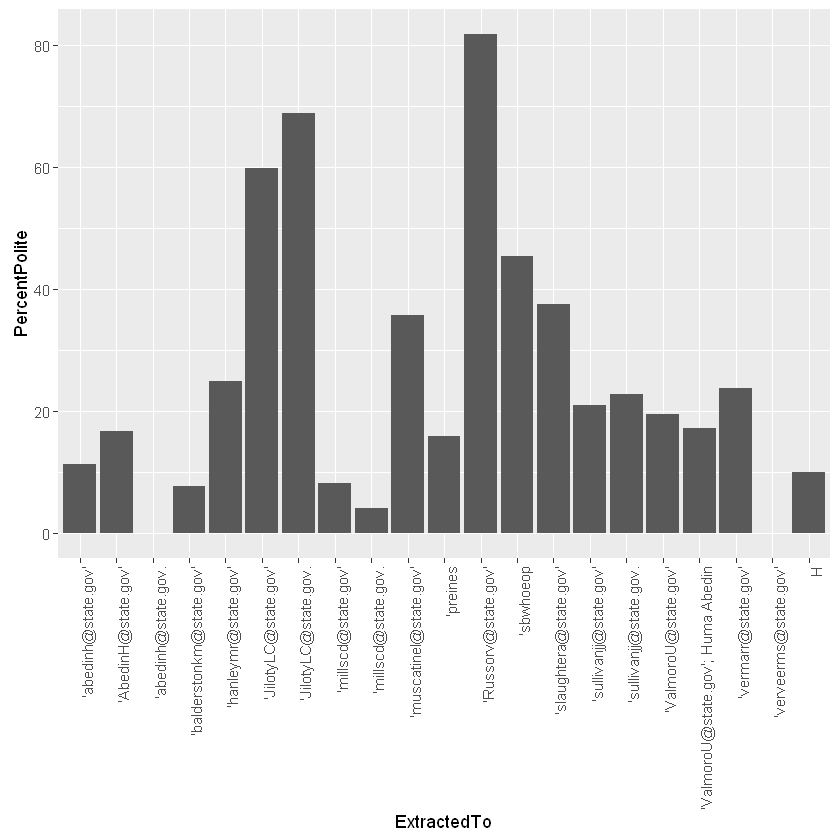

In [47]:
emailsFromHillary %>% 
  select(ExtractedTo, Politeness) %>%
  filter(ExtractedTo!="") %>%
  group_by(ExtractedTo) %>% 
  summarise(EmailCount= n(), PercentPolite=100*mean(Politeness=="Polite")) %>%
  filter(EmailCount>=10) %>%
  ggplot(aes(x = ExtractedTo, y = PercentPolite)) + 
  geom_bar(stat = "identity") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

# More than 80% of the emails from Hillary to Russorv@State.gov were polite.

In [48]:
#### With which all countries Hillary used to talk most #####

In [49]:
data(countrycode_data)

count.occurences <- function(needle, haystack)
{
  sapply(regmatches(haystack, gregexpr(needle, haystack, ignore.case=T, perl=T)), length)
}

In [50]:
#we assume that a country could be referred to as its full name or its ISO3 name as abbreviation
#so we get the list of countries

countrycode_data_without_atf <- countrycode_data[-83,]

countries <- countrycode_data_without_atf[, c("country.name", "regex", "iso2c", "iso3c")]

countries$other <- NA
countries[countries$country.name=="United Kingdom",]$other <- "UK"

In [57]:
emailsFromHillary <- dbGetQuery(db, "SELECT ExtractedBodyText EmailBody FROM Emails e INNER JOIN Persons p ON e.SenderPersonId=P.Id WHERE p.Name='Hillary Clinton'  AND e.ExtractedBodyText != '' ORDER BY RANDOM()")

all_hillary_emails <- paste(emailsFromHillary$EmailBody, collapse=" // ")

country_occurrences <-data.frame(countrycode_data_without_atf$country.name)
country_occurrences$occurences <- NA

words_to_remove <- rbind(DICTIONARY[nchar(DICTIONARY$word)==2,], DICTIONARY[nchar(DICTIONARY$word)==3,])

In [59]:
#add "RE" because the iso3 code for Reunion islands.. but it appears a lot in
#emails to indicate the RE(sponses) to previous emails.

#AL is a given name and also ISO2 for Albania
#BEN is a given name and also ISO3 for Benin
#LA is Los angeles and iso 2 for Liberia
#AQ is abbreviation of "As Quoted" and iso 2 for Antarctica


words_to_be_removed <- toupper(c(words_to_remove$word, "RE", "FM", "TV", "AL", "AQ", "LA", "BEN"))

for(i in 1:nrow(countries))
{
  
  n_occurences <- 0
  
  if(!is.na(countries[i,2]))
  {
    tmp <- count.occurences(countries[i,2], all_hillary_emails)
    n_occurences <- n_occurences + tmp
    
    if(tmp > 0)
      print(paste(tmp, countries[i,2]))
  }
  
  
  #remove words that are ISO2 country codes
  if( (! (countries[i,3] %in% words_to_be_removed) ) && (!is.na(countries[i,3]))  )
  {
    iso_boundary <- paste0("\\s", countries[i,3], "\\s")
    
    tmp <- count.occurences(iso_boundary, all_hillary_emails)
    
    n_occurences <- n_occurences + tmp
    
    if(tmp >0)
      print(paste(tmp, countries[i,3]))
  }
  
  
  #remove words that are ISO3 country codes
  if( (! (countries[i,4] %in% words_to_be_removed) ) && (!is.na(countries[i,4]))  )
  {
    iso_boundary <- paste0("\\s", countries[i,4],"\\s")
    
    tmp <- count.occurences(iso_boundary, all_hillary_emails)
    
    n_occurences <- n_occurences + tmp
    
    if(tmp >0)
      print(paste(tmp, countries[i,4]))
  }
  
  #remove words that are other country codes
  if( (! (countries[i,5] %in% words_to_be_removed) ) && (!is.na(countries[i,5]))  )
  {
    iso_boundary <- paste0("\\s", countries[i,5],"\\s")
    
    tmp <- count.occurences(iso_boundary, all_hillary_emails)
    
    n_occurences <- n_occurences + tmp
    
    if(tmp >0)
      print(paste(tmp, countries[i,5]))
  } 
  else if(tmp <= 0) {
    
    tmp <- count.occurences(countries[i,1], all_hillary_emails)
    
    n_occurences <- n_occurences + tmp
    
  }
  
  country_occurrences[i,]$occurences <- n_occurences
  
}

names(country_occurrences) <- c("country", "occurences")

gg_country_occurrences <- country_occurrences[country_occurrences$occurences >2,]

[1] "15 afghan"
[1] "4 AF"
[1] "3 angola"
[1] "1 AR"
[1] "1 armenia"
[1] "2 australia"
[1] "2 bahrain"
[1] "1 bermuda"
[1] "1 BT"
[1] "1 bolivia"
[1] "1 herzegovina|bosnia"
[1] "5 brazil"
[1] "1 cambodia|kampuchea|khmer|^p\\.?r\\.?k\\.?$"
[1] "2 CM"
[1] "2 canada"
[1] "1 CA"
[1] "1 christmas"
[1] "2 colombia"
[1] "2 \\bcook"
[1] "1 costa.?rica"
[1] "2 \\bcuba"
[1] "1 cyprus"
[1] "1 dominican"
[1] "4 egypt"
[1] "3 ET"
[1] "1 falkland|malvinas"
[1] "1 DD"
[1] "2 DE"
[1] "1 greece|hellenic|hellas"
[1] "2 greenland"
[1] "2 guatemala"
[1] "1 GW"
[1] "15 haiti"
[1] "5 india(?!.*ocea)"
[1] "1 indonesia"
[1] "8 \\biran|persia"
[1] "9 \\biraq|mesopotamia"
[1] "2 ireland"
[1] "7 israel"
[1] "1 italy"
[1] "1 japan"
[1] "1 JO"
[1] "1 kazak"
[1] "2 kuwait"
[1] "1 liberia"
[1] "42 libya"
[1] "2 lithuania"
[1] "1 macedonia|^f\\.?y\\.?r\\.?o\\.?m\\.?$"
[1] "1 malawi|nyasa"
[1] "4 marshall"
[1] "1 \\bmexic"
[1] "3 morocco|\\bmaroc"
[1] "1 myanmar|burma"
[1] "1 NC"
[1] "1 NI"
[1] "1 nigeria"
[1] "1 norw

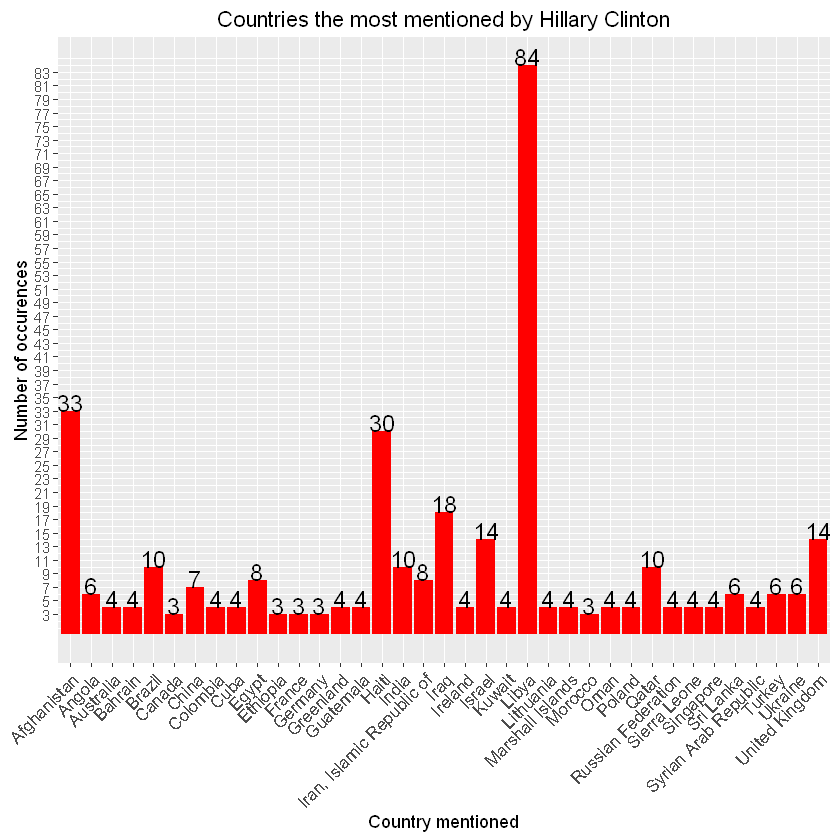

In [60]:
ggplot(gg_country_occurrences, aes(x=country, y=occurences)) + geom_bar(stat="identity", position = "identity", fill="red") + labs(x="Country mentioned", y="Number of occurences", title="Countries the most mentioned by Hillary Clinton") + scale_y_continuous(breaks=seq(min(gg_country_occurrences$occurences), max(gg_country_occurrences$occurences) ,by=2)) + theme(axis.text.x = element_text(size  = 10, angle = 45, hjust = 1, vjust = 1)) + geom_text(aes(label=occurences), vjust=0, size=5, color=rgb(0,0,0,1))